In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

In [2]:
import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [4]:
def cdist(X, Y):
    X2 = tf.reduce_sum(tf.square(X), 1)
    Y2 = tf.reduce_sum(tf.square(Y), 1)
    X2 = tf.reshape(X2, [-1, 1])
    Y2 = tf.reshape(Y2, [1, -1])
    # return pairwise euclidead difference matrix
    distances = tf.sqrt(tf.maximum(
        X2 + Y2 - 2 * tf.matmul(X, Y, False, True), 0.0))
    assert distances.shape == [X.shape[0], Y.shape[0]]
    return distances

In [5]:
def compute_T(K, u, v, n_iter, tol):
    """
    Parameters:
    -----------
        D: 2D array, [M, N]
        r: 1D array, [M, ]
        c: 1D array, [N, ]
        lambd: regularization parameter in Sinkhorn divergence
        p: power of the Wasserstein space
        n_iter: number of iterations for matrix balancing
        tol: tolerance for stopping matrix balancing iterations
    """
    r = tf.random.uniform([int(u.shape[0]), 1], dtype=tf.float64)
    c = tf.random.uniform([int(v.shape[0]), 1], dtype=tf.float64)
    r_new = tf.negative(tf.ones([int(u.shape[0]), 1], dtype=tf.float64))
    c_new = tf.negative(tf.ones([int(v.shape[0]), 1], dtype=tf.float64))

    def cond(r, c, r_new, c_new):
        r_enter = tf.reduce_any(tf.abs(r_new - r) > tol)
        c_enter = tf.reduce_any(tf.abs(c_new - c) > tol)
        return tf.logical_or(r_enter, c_enter)

    def body(r, c, r_new, c_new):
        r, c = r_new, c_new
        r_new = u / tf.matmul(K, c, False, False)
        c_new = v / tf.matmul(K, r_new, True, False)
        return [r, c, r_new, c_new]

    _, _, r, c = tf.while_loop(cond, body, [r, c, r_new, c_new], maximum_iterations=n_iter)

    T_opt = tf.matmul(tf.diag(tf.reshape(r, (-1,))),
                      tf.matmul(K, tf.diag(tf.reshape(c, (-1,)))))

    return T_opt

In [6]:
def wasserstein_distance(n1, n2, embeddings, u, v, lambd, p, n_iter, tol):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    D_p = tf.pow(D, p)
    K = tf.exp(-D_p / lambd)
    T = compute_T(K, u, v, n_iter, tol)

    # distance = tf.trace(tf.matmul(D_p, T, False, True)) + lambd * \
    #     tf.trace(tf.matmul(T, tf.log(T) -
    #                        tf.ones(T.shape, dtype=tf.float64), False, True))
    distance = tf.trace(tf.matmul(D_p, T, False, True))
    return distance

In [7]:
def embedding_distances(pairs, embeddings, u, v, lambd, p, n_iter, tol):

    results = tf.map_fn(lambda x: wasserstein_distance(
        x[0], x[1], embeddings, u, v, lambd, p, n_iter, tol), (pairs), dtype=tf.float64)
    return results

In [8]:
def train(node_pairs, obj_distances, n_epochs=500, patience=10, learning_rate=0.1, u_v=None, nodes=128, embed_dim=20, ground_dim=2, lambd=0.1, p=1, mat_bal_iter=20, mat_bal_tol=1e-5):
    if u_v is None:
        u = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
        v = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
    
    n_nodes = int(obj_distances.shape[0])

    Node_Pairs = tf.placeholder(dtype=tf.int32, shape=[n_nodes, 2], name='Node_Pairs')
    Obj_Distances = tf.placeholder(dtype=tf.float64, shape=[n_nodes], name='Obj_Distances')

    Embeddings = tf.Variable(tf.random.uniform(
        [nodes, embed_dim, ground_dim], dtype=tf.float64), name='Embeddings')
    Embed_Distances = embedding_distances(Node_Pairs, Embeddings, u, v, lambd, p, mat_bal_iter, mat_bal_tol)
    Loss = tf.reduce_mean(tf.abs(Embed_Distances - Obj_Distances) / Obj_Distances)
    Jac = tf.gradients(ys=Embed_Distances, xs=Embeddings)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(Loss)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        # Lists for storing the changing Cost and Accuracy in every Epoch
        loss_history = []

        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(n_epochs):
           # Running the Optimizer
            _, embeddings, embed_distances, loss, jac = sess.run([optimizer, Embeddings, Embed_Distances, Loss, Jac], feed_dict={Node_Pairs: node_pairs, Obj_Distances: obj_distances})
            # Storing loss to the history
            loss_history.append(loss)
            # Displaying result on current Epoch
            # if epoch % 10 == 0 and epoch != 0:
            logging.info("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
            # Early stopping check
            if loss < best_loss:
                best_loss = loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break
    return embeddings, loss_history, embed_distances, jac

In [9]:
from graph_generator import GraphGenerator

g = GraphGenerator(graph_type='scale-free', n_nodes=128, m=3)
node_pairs = g.get_node_pairs()
print(node_pairs.shape)
obj_distances = g.get_obj_distances()
print(obj_distances.shape)

(8128, 2)
(8128,)


In [65]:
import networkx as nx

In [11]:
embeddings, loss_history, embed_distances, jac = train(node_pairs, obj_distances, learning_rate=0.5, n_epochs=2000, patience=5, 
                                                       embed_dim=15, lambd=1., mat_bal_iter=20)

2019-04-24 22:56:15,534 - INFO - Epoch: 0/2000, loss: 0.8040404394726478
2019-04-24 22:56:52,682 - INFO - Epoch: 1/2000, loss: 0.6034714800583868
2019-04-24 22:57:48,663 - INFO - Epoch: 2/2000, loss: 0.4499510248187679
2019-04-24 22:59:09,616 - INFO - Epoch: 3/2000, loss: 0.3403253575284184
2019-04-24 23:00:46,814 - INFO - Epoch: 4/2000, loss: 0.30485341151240913
2019-04-24 23:02:26,899 - INFO - Epoch: 5/2000, loss: 0.3167307018549681
2019-04-24 23:04:23,898 - INFO - Epoch: 6/2000, loss: 0.33272539166453
2019-04-24 23:06:06,257 - INFO - Epoch: 7/2000, loss: 0.3287096588601522
2019-04-24 23:07:50,965 - INFO - Epoch: 8/2000, loss: 0.30559554644627057
2019-04-24 23:09:36,995 - INFO - Epoch: 9/2000, loss: 0.272938868059585
2019-04-24 23:11:24,933 - INFO - Epoch: 10/2000, loss: 0.24294083170009656
2019-04-24 23:13:19,853 - INFO - Epoch: 11/2000, loss: 0.22428116925997382
2019-04-24 23:15:36,981 - INFO - Epoch: 12/2000, loss: 0.2166440775605265
2019-04-24 23:17:30,320 - INFO - Epoch: 13/2000

2019-04-25 02:12:38,087 - INFO - Epoch: 110/2000, loss: 0.11160623286950282
2019-04-25 02:14:25,574 - INFO - Epoch: 111/2000, loss: 0.11158143578585607
2019-04-25 02:16:13,256 - INFO - Epoch: 112/2000, loss: 0.1115370778548043
2019-04-25 02:18:00,265 - INFO - Epoch: 113/2000, loss: 0.11139643453244957
2019-04-25 02:19:47,509 - INFO - Epoch: 114/2000, loss: 0.1112917257391173
2019-04-25 02:21:40,273 - INFO - Epoch: 115/2000, loss: 0.11125607874572588
2019-04-25 02:23:27,377 - INFO - Epoch: 116/2000, loss: 0.11112634987070616
2019-04-25 02:25:14,776 - INFO - Epoch: 117/2000, loss: 0.11104451510406638
2019-04-25 02:27:01,613 - INFO - Epoch: 118/2000, loss: 0.11103156626406599
2019-04-25 02:28:48,733 - INFO - Epoch: 119/2000, loss: 0.11092029100804758
2019-04-25 02:30:37,486 - INFO - Epoch: 120/2000, loss: 0.11079449266171339
2019-04-25 02:32:25,045 - INFO - Epoch: 121/2000, loss: 0.1107687935078625
2019-04-25 02:34:14,271 - INFO - Epoch: 122/2000, loss: 0.11065020834862292
2019-04-25 02:3

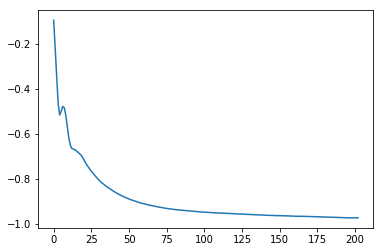

In [14]:
log_loss = np.log10(loss_history)
plt.figure()
plt.plot(log_loss)
plt.show()

In [16]:
from scipy.spatial.distance import squareform
import seaborn as sns

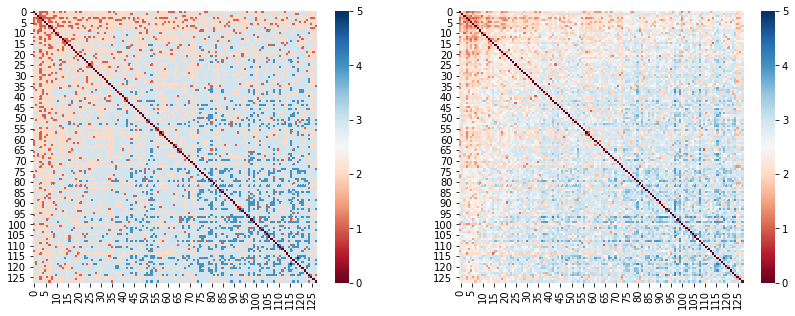

In [27]:
plt.figure(figsize=(14,5))

true_distance = squareform(obj_distances)
plt.subplot(121)
sns.heatmap(true_distance, cmap='RdBu')

pred_distance = squareform(embed_distances)
plt.subplot(122)
sns.heatmap(pred_distance, cmap='RdBu', vmin=0, vmax=5)